In [1]:
import os
from os import listdir
from os.path import isfile, join
import time
import re
import copy
import numpy as np
import pandas as pd
import h5py
import tables
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import rioxarray as rxr
import math
import pickle 
import sklearn
from pickle import dump
import rasterio
import geopandas as gpd
from shapely.geometry import Point
from mpl_toolkits.basemap import Basemap
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from platform import python_version
import warnings; warnings.filterwarnings("ignore")


def atof(text):
    try:
        retval = float(text)
    except ValueError:
        retval = text
    return retval

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    float regex comes from https://stackoverflow.com/a/12643073/190597
    '''
    return [ atof(c) for c in re.split(r'[+-]?([0-9]+(?:[.][0-9]*)?|[.][0-9]+)', text) ]



print(pd.__version__) # should be 1.3.0
print(sklearn.__version__) # should be 0.24.1
print(tf.__version__) # should be 2.4.0
print(python_version()) #should be 3.8.2

C:\Users\rjohnson18\Anaconda3\envs\NSM_env\lib\site-packages\xarray\backends\cfgrib_.py:29: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
C:\Users\rjohnson18\Anaconda3\envs\NSM_env\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


1.4.3
1.1.1
2.9.1
3.9.12


In [2]:
def MLP_train_predict(Region_optfeatures, RegionTrain, Region, epochs, MLP_Models):
       
    #get y data
    y = RegionTrain[Region]['SWE']
    
    #get max SWE for normalization and prediction
    SWEmax = max(RegionTrain[Region]['SWE'])
    y = y/SWEmax

    #get optimal features for each regions (from LGBM RFE)
    optfeatures = list(Region_optfeatures[Region])
    
    #make a df copy of specific region
    df = RegionTrain.get(Region).copy()
    df = df[optfeatures]
    
    ### replace special character ':' with '__' 
    df = df.rename(columns = lambda x:re.sub(':', '__', x))

    #change all na values to prevent scaling issues
    df[df< -9000]= -10

    #normalize training data    
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(df)
    df = pd.DataFrame(scaled, columns = df.columns)


    
    X = df
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)
    
    #set up prediction dataframe
    pred_obs = pd.DataFrame(y_test)
    pred_obs = pred_obs.rename(columns = {'SWE':'y_test'})
    
    
    #set up model checkpoint to be able to extract best models
    checkpointfilename ='SWE_{val_loss:.8f}.h5'
    checkpoint_filepath = 'Model/Model_Training/'+MLP_Models+'/' +Region+ '/'
    
    #save scaler data here too
    dump(scaler, open(checkpoint_filepath+'scaler.pkl', 'wb'))
    
    checkpoint_filename = checkpoint_filepath+checkpointfilename
    callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filename,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
    
     #need to save SWEmax
    SWEmax = np.array(SWEmax)
    np.save(checkpoint_filepath+'SWEmax.npy' , SWEmax)

    #get the training data shape to form MLP model input layer
    shape = X_train.shape

    #set up layer-nodes for MLP model
    LD1=128
    #seems like only slight increase in runtime with another layer
    LD2=128
    #seems like only slight increase in runtime with another layer
    LD3=64
    #seems like only slight increase in runtime with another layer, sig per improvement 
    LD4=64
    LD5=32
    LD6=16
    LD7=5

    input_1 = layers.Input(shape=(shape[1],))
    x = layers.Dense(LD1, activation="relu")(input_1)
    x = layers.Dense(LD2, activation="relu")(x)
    x = layers.Dense(LD3, activation="relu")(x)
    x = layers.Dense(LD4, activation="relu")(x)
    x = layers.Dense(LD5, activation="relu")(x)
    x = layers.Dense(LD6, activation="relu")(x)
    x = layers.Dense(1)(x)

    model = keras.Model(inputs=input_1,outputs=x)
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(1e-4), metrics=['mse'])
    print(model.summary())
    #training time for 50 epochs took 3601seconds, 60 mins, 500 epochs
    model.fit(X_train, y_train, epochs=epochs, batch_size=100,
                        validation_data=(X_test,y_test),shuffle=True,callbacks=[callback], verbose=0)
    
    
    
     #load the model with highest performance
    bestmodel = [f for f in listdir(checkpoint_filepath) if isfile(join(checkpoint_filepath, f))]
    bestmodel.sort(key=natural_keys)
    bestmodel = checkpoint_filepath+bestmodel[0]
    model=load_model(bestmodel)
    print(bestmodel)
    
    
    #make predictions and rescale, the 10 is bc changed -9999 values to -10
    y_pred = (SWEmax* model.predict(X_test))

    y_pred[y_pred < 0 ] = 0
    y_test = (SWEmax * y_test)
    pred_obs['y_test'] = y_test
    pred_obs['y_pred'] = y_pred 
    pred_obs['Region'] = region
    
    #Run model evaluate function
    print(model.evaluate(X_train, y_train))
    r2_test = sklearn.metrics.r2_score(y_test, y_pred)
    rmse_test = sklearn.metrics.mean_squared_error(y_test, y_pred, squared = False)
    print(' R2 is ', r2_test)
    print(' RMSE is ', rmse_test)
    print("MSE: %.4f" % mean_squared_error(y_test, y_pred))
    
    error_data = np.array([region, round(r2_test,2),  round(rmse_test,2)])
    error = pd.DataFrame(data = error_data.reshape(-1, len(error_data)), columns = ['Region', 'R2', 'RMSE'])
    print(error)


    #plot graph
    plt.scatter( pred_obs['y_test'],pred_obs['y_pred'], s=5, color="blue", label="Predictions")
    plt.plot([0,SWEmax], [0,SWEmax], color = 'red', linestyle = '--')
    plt.xlabel('Observed SWE')
    plt.ylabel('Predicted SWE')

    #plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
    plt.title(region)
    plt.legend()
    plt.show()
    
    return pred_obs, error

In [3]:
os.getcwd()
os.chdir('..')
os.getcwd()
os.chdir('..')
os.getcwd()

'C:\\Users\\rjohnson18\\Box\\CIROH\\SnowModeling\\ESIP\\JupyterBook_Tutorial\\GeoSmart_ML_Tutorial\\book\\chapters'

In [305]:
'''
Analyis indicates that the Prev_SWE -9999 values is responsible for nearly all model error (in Sierras),
make training DF that removes -9999 prev_SWE rows from training
implement for other regions and models,!!!!!
might need to explore removing cites with -9999 observations...
'''

### define new regions
Region_list = [
               'N_Co_Rockies',
              ]

#make model file directories
#for region in Region_list:
#    os.makedirs('Model/Model_Training/MLP/'+region)

#load RFE optimized features
Region_optfeatures= pickle.load(open("Model/Model_Features/Optimal_Features.pkl", "rb"))

### Load H5 train files into dictionary
RegionTrain= {}
for region in Region_list:
    RegionTrain[region] = pd.read_hdf('Provided_Data/Final_Training_DF.h5', region)
    
#Reorder regions
RegionTrain = {k: RegionTrain[k] for k in Region_list}

Training model for  N_Co_Rockies
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 35)]              0         
                                                                 
 dense (Dense)               (None, 128)               4608      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)            

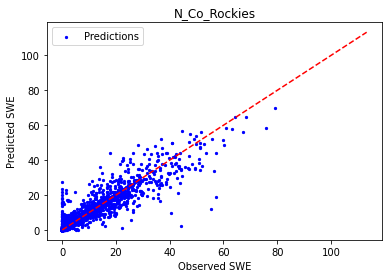

306.8190586566925


In [6]:
Model_Results= pd.DataFrame(columns = ['y_test', 'y_pred',  'Region'])
Model_Error = pd.DataFrame(columns = ['Region', 'R2', 'RMSE'])

t0 = time.time()
for region in Region_list:
    print('Training model for ', region)
    #Training model and getting results
    pred_obs, error = MLP_train_predict(Region_optfeatures, RegionTrain, region, 3000, 'MLP')
    Model_Results = Model_Results.append(pred_obs)
    Model_Error = Model_Error.append(error)
    #Save predictions
    pred_obs.to_hdf('Model/Model_Training/Model_Validation/Region_Predictions.h5', key= region, complevel = 9, complib = 'bzip2')
t1 = time.time()
print(t1-t0 'seconds')

## More in-depth model evaluation.
We want to evaluate the model over the course of seasonal snow accumulation and melt, at differnt elevation bands, and spatially.

In [306]:
#get y data
def Eval_DF(RegionTrain, Region, Predictions):
    #get the testing split
    y = RegionTrain[Region]['SWE']
    X = RegionTrain[Region]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)
    
    #Combine predictions with testing testing dependent DF,     
    X_test['y_pred'] = Predictions[Region]['y_pred']
    X_test['error'] = X_test['SWE'] - X_test['y_pred']
    
    #select key topographical and temporal features of interest for model evaluation
    cols = ['Date', 'Long', 'Lat', 'elevation_m', 'prev_SWE', 'WYWeek', 'northness', 'SWE','y_pred', 'error']
    X_test = X_test[cols]
    
    return X_test

In [307]:
#Load the predictions
pred_obs = {}
pred_obs['N_Co_Rockies'] = pd.read_hdf('Model/Model_Training/Model_Validation/Region_Predictions.h5', key = 'N_Co_Rockies')


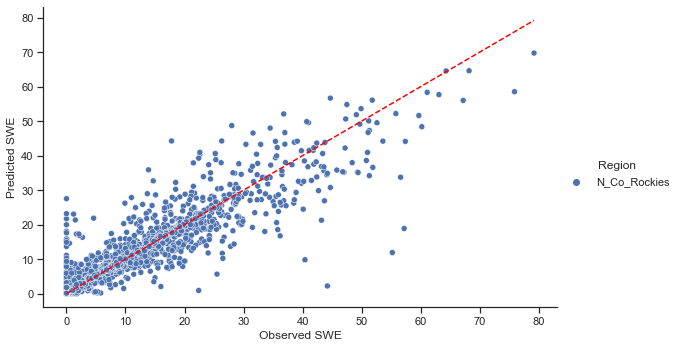

In [308]:
#Plot all predictions

sns.set(style='ticks')
SWEmax = max(Model_Results['y_test'])

sns.relplot(data=Model_Results, x='y_test', y='y_pred', hue='Region', hue_order=Region_list, aspect=1.61)
plt.plot([0,SWEmax], [0,SWEmax], color = 'red', linestyle = '--')
plt.xlabel('Observed SWE')
plt.ylabel('Predicted SWE')
plt.show()

In [309]:
#Process the data into a useful dataframe for analysis
x = Eval_DF(RegionTrain, 'N_Co_Rockies', pred_obs)

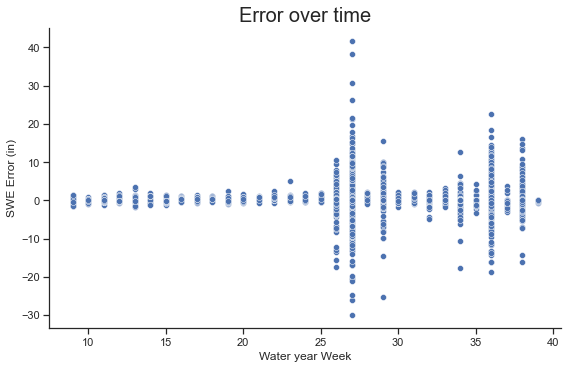

In [310]:
#Plot the temporal error
sns.set(style='ticks')
sns.relplot(data=x, x='WYWeek', y='error', hue_order=Region_list, aspect=1.61)
plt.xlabel('Water year Week')
plt.ylabel('SWE Error (in)')
plt.title("Error over time", fontsize = 20)
plt.show()


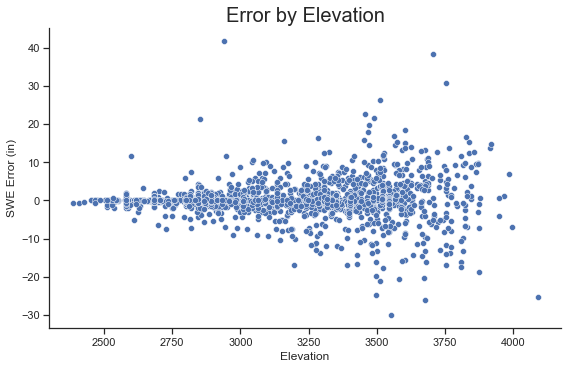

In [311]:
#Plot the error by elevation
sns.set(style='ticks')
sns.relplot(data=x, x='elevation_m', y='error', hue_order=Region_list, aspect=1.61)
plt.xlabel('Elevation')
plt.ylabel('SWE Error (in)')
plt.title("Error by Elevation", fontsize = 20)
plt.show()

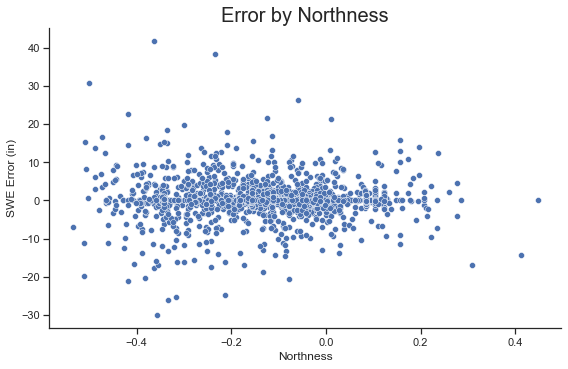

In [312]:
#Plot the error by slope/angle = northness
sns.set(style='ticks')
sns.relplot(data=x, x='northness', y='error', hue_order=Region_list, aspect=1.61)
plt.xlabel('Northness')
plt.ylabel('SWE Error (in)')
plt.title("Error by Northness", fontsize = 20)
plt.show()

In [88]:
#load regionalized geospatial data
RegionTrain = open("Provided_Data/RegionTrain.pkl", "rb")
RegionSnotel = open("Provided_Data/RegionSnotel.pkl", "rb")

RegionTrain = pickle.load(RegionTrain)
RegionSnotel = pickle.load(RegionSnotel)

Create two dataframes, one for geospatial information of prediction locations and another for the time series of pred/obs/error

In [110]:
#Create Geospatial prediction point DF
Pred_Geo = RegionTrain['N_Co_Rockies'].copy()
Pred_Geo = Pred_Geo.reset_index().drop_duplicates(subset='cell_id', keep='last').set_index('cell_id').sort_index()
cols = ['Long','Lat','elevation_m','slope_deg','aspect']
Pred_Geo= Pred_Geo[cols].reset_index()
Pred_Geo

cell_id        Long        Lat  \
0     0027a004-df14-4d66-a3e4-e987336b8814 -106.802801  38.883190   
1     0036f966-3430-45f3-b6a2-803e678a1c2b -106.955515  39.029885   
2     003cec54-9e23-4c5b-8577-fc968ba1e9d2 -105.949401  39.537461   
3     007a29fe-066d-4bb9-b349-35c24b57ad87 -107.251959  39.015927   
4     008bbce5-1193-41c0-bda1-7ae421f700b8 -106.793818  38.743197   
...                                    ...         ...        ...   
1752  ff38e604-71fc-4be8-8352-59c4ecbf8943 -106.712969  38.764214   
1753  ff49d2dc-04bc-4e3c-b911-760fc14966a6 -106.748902  38.687124   
1754  ff8508d6-2a06-485f-a896-7c67b9fd79e8 -107.054329  39.036863   
1755  ffae0d8b-736b-4a85-a99c-ff47c07ca7dd -106.766868  39.008947   
1756  ffca2dc2-ed02-4006-82a3-fa093863fa68 -105.967368  39.412647   

      elevation_m  slope_deg  aspect  
0         3233.50      17.50  119.25  
1         3608.75      16.75   81.50  
2         3275.00      16.25  186.75  
3         3269.50      19.50  201.25  
4         2901.50      14.75  119.25  
...           ...        ...     ...  
1752      3168.25      15.75  169.00  
1753      2729.75      11.00  166.75  
1754      3277.75      17.50  180.50  
1755      3659.00      12.50  145.00  
1756      3527.75      10.50  144.75  

[1757 rows x 6 columns]

In [402]:
import geopandas as gpd
import folium
from folium import features
from folium.plugins import StripePattern
import branca.colormap as cm
import vincent
from vincent import AxisProperties, PropertySet, ValueRef, Axis
import hvplot.pandas
import holoviews as hv
from holoviews import dim, opts, streams
from bokeh.models import HoverTool
import hydroeval as he
import json


#Map locations and scoring of sites
#def Map_Plot_Eval(self, freq, df, size):
def Map_Plot_Eval(GeoDF, Snotel, obs, err, pred, yaxis):   

    print('Plotting monitoring station locations')
    cols =  ['cell_id', 'Lat', 'Long', 'geometry']

    df_map = GeoDF[cols].copy()

    #Get Centroid of watershed
    centeroid = df_map.dissolve().centroid

    # Create a Map instance
    m = folium.Map(location=[centeroid.y[0], centeroid.x[0]], tiles = 'Stamen Terrain', zoom_start=8, 
                   control_scale=True)
    #add legend to map
    colormap = cm.StepColormap(colors = ['darkred', 'r', 'orange', 'g'], vmin = 0, vmax = 1, index = [0,0.4,0.6,0.85,1])
    colormap.caption = 'Model Performance (KGE)'
    m.add_child(colormap)

    ax = AxisProperties(
    labels=PropertySet(
        angle=ValueRef(value=300),
        align=ValueRef(value='right')
            )
        )

    for i in obs.columns:


        #get site information
        site = i
        Obs_site = 'Observations'#_' + site
        Pred_site = 'Predictions'#_' + site
        Err_site = 'Errors'#_' + site


        #get modeled, observed, and error information for each site
        df = pd.DataFrame(obs[site])
        df = df.rename(columns = {site: Obs_site})
        df[Pred_site] = pd.DataFrame(pred[site])
        df[Err_site] = pd.DataFrame(err[site])

        #set the color of marker by model performance
        kge, r, alpha, beta = he.evaluator(he.kge, df[Pred_site].astype('float32'), df[Obs_site].astype('float32'))

        if kge[0] > 0.85:
            color = 'green'

        elif kge[0] > 0.6:
            color = 'orange'

        elif kge[0] > 0.40:
            color = 'red'

        else:
            color = 'darkred'

        title_size = 14

        #create graph and convert to json
        graph = vincent.Scatter(df, height=300, width=500)
        graph.axis_titles(x='Datetime', y=yaxis)
        graph.legend(title= 'Legend')
        graph.colors(brew='Set1')
        graph.x_axis_properties(title_size=title_size, title_offset=35,
                      label_angle=300, label_align='right', color=None)
        graph.y_axis_properties(title_size=title_size, title_offset=-30,
                      label_angle=None, label_align='right', color=None)

        data = json.loads(graph.to_json())

        #Add marker with point to map, https://fontawesome.com/v4/cheatsheet  - needs to be v4.6 or less
        lat_long = df_map[df_map['cell_id'] == i]
        lat = lat_long['Lat'].values[0]
        long = lat_long['Long'].values[0]

        mk = features.Marker([lat, long], icon=folium.Icon(color=color, icon = ' fa-ge', prefix = 'fa'))
        p = folium.Popup()
        v = features.Vega(data, width="100%", height="100%")

        mk.add_child(p)
        p.add_child(v)
        m.add_child(mk)
        
        
    # add SNOTEL marker one by one on the map
    for i in range(0,len(Snotel)):
        

        folium.Marker(
          location=[Snotel.iloc[i]['Lat'], Snotel.iloc[i]['Long']],
            icon=folium.Icon(color='blue', icon = 'fa-area-chart', prefix = 'fa'),
            tooltip = str(Snotel.iloc[i]['location']) + ": " + str(Snotel.iloc[i]['station_id']),
          popup= str(Snotel.iloc[i]['location']) + ": " + str(Snotel.iloc[i]['elevation_m']) + "m",
       ).add_to(m)

    display(m)
    
    
def df_transpose(df, obs):
    #get index
    date_idx = df.index.unique()
    #get columns names, aka sites
    sites = df['cell_id'].values
    #make dataframe
    DF =pd.DataFrame(index = date_idx)
    for site in sites:
        s = pd.DataFrame(df[df['cell_id'] == site][obs])
        DF = DF.join(s)
        DF = DF.rename(columns ={obs: site})
    DF = DF.loc[:,~DF.columns.duplicated()].copy()
    return DF 

In [ ]:
#need to put the predictions, obs, error in s time series format
x.index = x.index.set_names(['cell_id'])

#predictions
x_pred = x.copy()
cols = ['Date','y_pred']
x_pred = x_pred[cols].reset_index().set_index('Date').sort_index()
x_pred = df_transpose(x_pred, 'y_pred')

#observations
x_obs = x.copy()
cols = ['Date','SWE']
x_obs = x_obs[cols].reset_index().set_index('Date').sort_index()
x_obs = df_transpose(x_obs, 'SWE')

#error
x_err = x.copy()
cols = ['Date','error']
x_err = x_err[cols].reset_index().set_index('Date').sort_index()
x_err = df_transpose(x_err, 'error')

In [381]:
#Get SNOTEL sites used as features
Sites = [match for match in Region_optfeatures['N_Co_Rockies'] if 'Delta_SWE'  in match]
for i in np.arange(0, len(Sites),1):
    Sites[i] = Sites[i].replace('Delta_SWE_', '')   


    
#Convert the Prediction Geospatial dataframe into a geopandas dataframe
GeoDF = gpd.GeoDataFrame(Pred_Geo, geometry = gpd.points_from_xy(Pred_Geo.Long, Pred_Geo.Lat))
SNOTEL_Geo = gpd.GeoDataFrame(RegionSnotel['N_Co_Rockies'], geometry = gpd.points_from_xy(RegionSnotel['N_Co_Rockies'].Long, RegionSnotel['N_Co_Rockies'].Lat))

#Select sites used for prediction
SNOTEL_Geo = SNOTEL_Geo.set_index('station_id').T[Sites].T.reset_index()

In [403]:
#Run folium plotting function
Map_Plot_Eval(GeoDF,SNOTEL_Geo, x_obs, x_err, x_pred, 'SWE (in)')

Plotting monitoring station locations


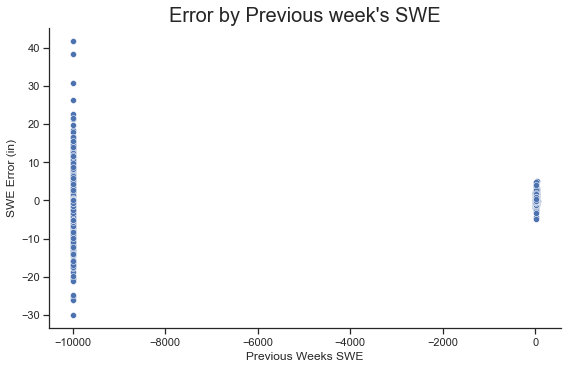

In [322]:
#Plot the error by the previous weeks SWE
sns.set(style='ticks')
sns.relplot(data=x, x='prev_SWE', y='error', hue_order=Region_list, aspect=1.61)
plt.xlabel('Previous Weeks SWE')
plt.ylabel('SWE Error (in)')
plt.title("Error by Previous week's SWE", fontsize = 20)
plt.show()

### Missing Previous week's values have a substantial impact on model performance.
Lets look at the predictions that have a previous week's value and evaluate

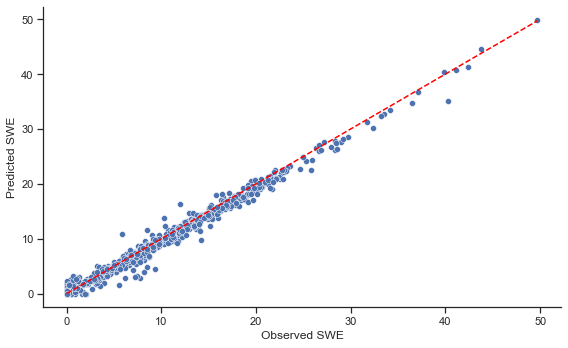

 R2 is  0.9840870705158689
 RMSE is  0.95247451137688


In [323]:
#select for locations where there is a previous week's observation
x_prev = x[x['prev_SWE']>=0]

SWEmax = max(x_prev['SWE'])

sns.relplot(data=x_prev, x='SWE', y='y_pred', hue_order=Region_list, aspect=1.61)
plt.plot([0,SWEmax], [0,SWEmax], color = 'red', linestyle = '--')
plt.xlabel('Observed SWE')
plt.ylabel('Predicted SWE')
plt.show()

#Run model evaluate functions
r2_test = sklearn.metrics.r2_score(x_prev['SWE'], x_prev['y_pred'])
rmse_test = sklearn.metrics.mean_squared_error(x_prev['SWE'], x_prev['y_pred'], squared = False)
print(' R2 is ', r2_test)
print(' RMSE is ', rmse_test)

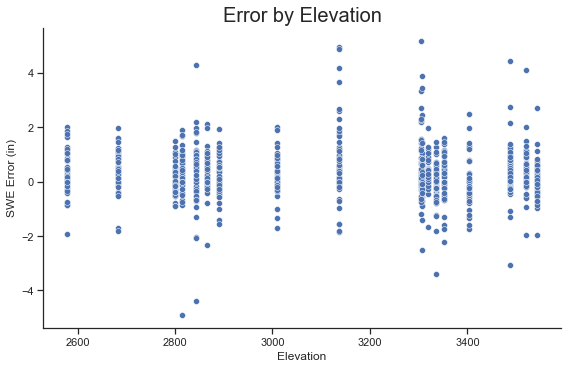

In [324]:
#Plot the error by elevation
sns.set(style='ticks')
sns.relplot(data=x_prev, x='elevation_m', y='error', hue_order=Region_list, aspect=1.61)
plt.xlabel('Elevation')
plt.ylabel('SWE Error (in)')
plt.title("Error by Elevation", fontsize = 20)
plt.show()

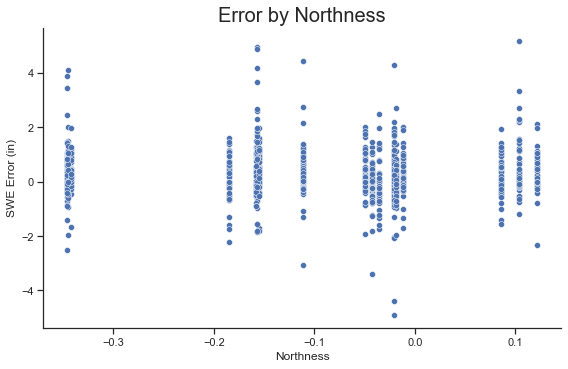

In [325]:
#Plot the error by slope/angle = northness
sns.set(style='ticks')
sns.relplot(data=x_prev, x='northness', y='error', hue_order=Region_list, aspect=1.61)
plt.xlabel('Northness')
plt.ylabel('SWE Error (in)')
plt.title("Error by Northness", fontsize = 20)
plt.show()

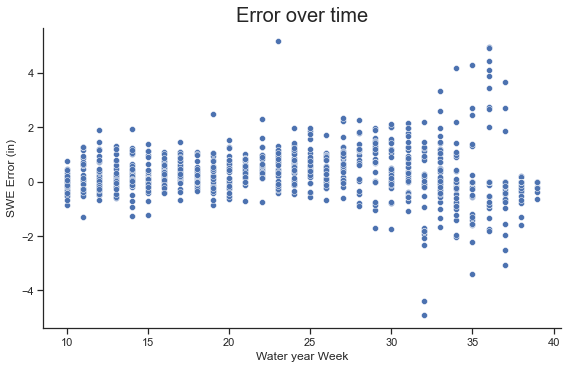

In [326]:
#Plot the temporal error
sns.set(style='ticks')
sns.relplot(data=x_prev, x='WYWeek', y='error', hue_order=Region_list, aspect=1.61)
plt.xlabel('Water year Week')
plt.ylabel('SWE Error (in)')
plt.title("Error over time", fontsize = 20)
plt.show()

In [335]:
#need to put the predictions, obs, error in s time series format
x_prev.index = x_prev.index.set_names(['cell_id'])

#predictions
x_pred = x_prev.copy()
cols = ['Date','y_pred']
x_pred = x_pred[cols].reset_index().set_index('Date').sort_index()
x_pred = df_transpose(x_pred, 'y_pred')

#observations
x_obs = x_prev.copy()
cols = ['Date','SWE']
x_obs = x_obs[cols].reset_index().set_index('Date').sort_index()
x_obs = df_transpose(x_obs, 'SWE')

#error
x_err = x_prev.copy()
cols = ['Date','error']
x_err = x_err[cols].reset_index().set_index('Date').sort_index()
x_err = df_transpose(x_err, 'error')



In [342]:
#Run folium plotting function
Map_Plot_Eval(GeoDF, x_obs, x_err, x_pred, 'SWE (in)')

Plotting monitoring station locations


## Exploring the Prediction results

Effective modeling of elevation gradients leads to a smooth realization of modeled SWE across heterogeneous terrain. 
For example, the lower bounds of the higher elevation band of the South Sierras display greater modeled SWE values compared to higher elevations associated with exposed terrain subject to wind transport and snow redistribution (\citealp{grunewald2014elevation}). Similarly, the transition from South to North exhibits greater SWE trending towards northward Latitudes and reflecting regional climate patterns.
In the Greater Yellowstone region, the model captures the distinct trend of low SWE at lower elevations and higher SWE at higher elevations (Figure \ref{fig:regions_SWE}). 
This is indicative that the model is robust to differing generalized topographical and geographical characteristics across the western US, and is capable of capturing elevation gradients effectively.
While the model uses northness as a feature to represent the average slope and aspect of the 1-km grid, overlaying the predictions on complex topography indicates a need for high resolution prediction.
Examination of the 1-km resolution indicates it is too coarse to capture rapid topographical changes common to montane environments.
Future research plans are to identify the optimal spatial resolution for operational hydrological modeling, where there is a balance the modeling of the spatial resolution catchment SWE distribution and computational capacity.

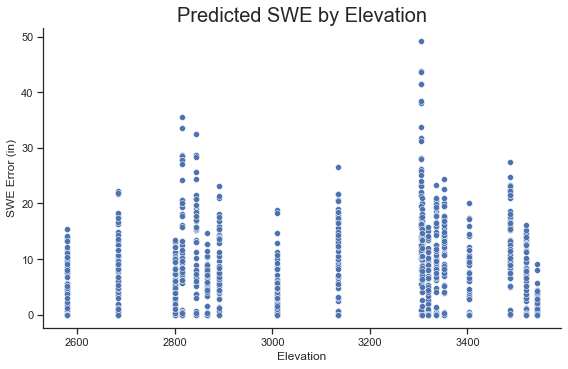

In [82]:
#Plot the SWE by elevation
sns.set(style='ticks')
sns.relplot(data=x_prev, x='elevation_m', y='y_pred', hue_order=Region_list, aspect=1.61)
plt.xlabel('Elevation')
plt.ylabel('SWE Error (in)')
plt.title("Predicted SWE by Elevation", fontsize = 20)
plt.show()

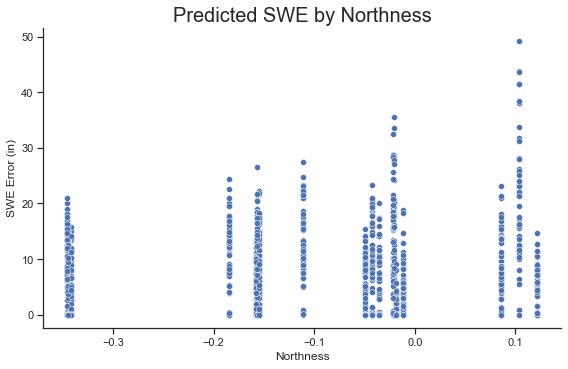

In [87]:
#Plot the SWE by northness
sns.set(style='ticks')
sns.relplot(data=x_prev, x='northness', y='y_pred', hue_order=Region_list, aspect=1.61)
plt.xlabel('Northness')
plt.ylabel('SWE Error (in)')
plt.title("Predicted SWE by Northness", fontsize = 20)
plt.show()

In [84]:
x_prev

Date        Long        Lat  \
e4473542-1804-41c0-82b2-eaddc245845d 2014-05-06 -105.733806  40.432232   
e4473542-1804-41c0-82b2-eaddc245845d 2014-01-14 -105.733806  40.432232   
c92e4b92-91a1-47e2-be14-c03c6fe3bc96 2014-04-08 -107.287891  39.127513   
f62e6b4d-7f9d-4139-bac4-59f084fb09cd 2017-06-27 -106.515340  39.599784   
e4473542-1804-41c0-82b2-eaddc245845d 2013-06-11 -105.733806  40.432232   
...                                         ...         ...        ...   
629e076c-b9b1-4716-8e60-a225668de40f 2013-03-05 -105.904486  39.675880   
cad51334-b3af-4c23-85c3-451c3447560a 2016-02-23 -105.904486  39.765704   
c92e4b92-91a1-47e2-be14-c03c6fe3bc96 2019-12-17 -107.287891  39.127513   
7ee904e8-b3a9-4e1b-993c-653c826159ba 2013-01-15 -107.638234  39.092662   
2540867d-30aa-41cd-ae38-247adfc662e8 2015-03-31 -106.542289  39.085689   

                                      elevation_m  prev_SWE  WYWeek  \
e4473542-1804-41c0-82b2-eaddc245845d      3336.50      19.5      31   
e4473542-1804-41c0-82b2-eaddc245845d      3336.50       6.7      15   
c92e4b92-91a1-47e2-be14-c03c6fe3bc96      2682.75      18.1      27   
f62e6b4d-7f9d-4139-bac4-59f084fb09cd      2578.00       0.0      38   
e4473542-1804-41c0-82b2-eaddc245845d      3336.50       0.0      36   
...                                           ...       ...     ...   
629e076c-b9b1-4716-8e60-a225668de40f      3486.50       9.8      22   
cad51334-b3af-4c23-85c3-451c3447560a      3307.00      11.5      21   
c92e4b92-91a1-47e2-be14-c03c6fe3bc96      2682.75       3.7      11   
7ee904e8-b3a9-4e1b-993c-653c826159ba      3009.00       5.0      15   
2540867d-30aa-41cd-ae38-247adfc662e8      3318.25      11.1      26   

                                      northness   SWE     y_pred     error  
e4473542-1804-41c0-82b2-eaddc245845d  -0.042223  19.4  18.720011  0.679989  
e4473542-1804-41c0-82b2-eaddc245845d  -0.042223   7.5   8.716754 -1.216754  
c92e4b92-91a1-47e2-be14-c03c6fe3bc96  -0.155094  18.3  17.582193  0.717807  
f62e6b4d-7f9d-4139-bac4-59f084fb09cd  -0.049846   0.0   0.393168 -0.393168  
e4473542-1804-41c0-82b2-eaddc245845d  -0.042223   0.0   0.518822 -0.518822  
...                                         ...   ...        ...       ...  
629e076c-b9b1-4716-8e60-a225668de40f  -0.110793  11.2  11.448389 -0.248389  
cad51334-b3af-4c23-85c3-451c3447560a  -0.346136  12.2  11.965387  0.234613  
c92e4b92-91a1-47e2-be14-c03c6fe3bc96  -0.155094   4.8   5.365340 -0.565340  
7ee904e8-b3a9-4e1b-993c-653c826159ba  -0.012023   5.0   4.876959  0.123041  
2540867d-30aa-41cd-ae38-247adfc662e8  -0.342089  11.1  11.188616 -0.088616  

[918 rows x 10 columns]